In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_value_added_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')

In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

In [4]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['id'], halocat.halo_table['halo_id'])

In [41]:
histories['mpeak'] = 0.
histories['mpeak'][idxA] = halocat.halo_table['halo_mpeak'][idxB]

histories['x'] = 0.
histories['y'] = 0.
histories['z'] = 0.
histories['x'][idxA] = halocat.halo_table['halo_x'][idxB]
histories['y'][idxA] = halocat.halo_table['halo_y'][idxB]
histories['z'][idxA] = halocat.halo_table['halo_z'][idxB]

In [6]:
print("{0:.3e}".format(np.log10(histories['mpeak'].min())))

1.068e+01


In [7]:
mpeak_bins = np.insert(np.append(np.logspace(11, 14, 20), np.inf), 0, -np.inf)
result = np.histogram(histories['mpeak'], mpeak_bins)[0]
print(result)

[ 2115 11354 40962 73065 70288 53815 38898 27496 20058 14103 10191  6994
  5009  3434  2399  1655  1122   773   482   338   461]


In [8]:
mean_sm_all = np.zeros(len(mpeak_bins)-1)
std_sm_all = np.zeros(len(mpeak_bins)-1)
mpeak_mids_all = np.zeros(len(mpeak_bins)-1)
for i, mlow, mhigh in zip(range(len(mpeak_bins)), mpeak_bins[:-1], mpeak_bins[1:]):
    mask = (histories['mpeak'] > mlow) & (histories['mpeak'] < mhigh)
    mean_sm_all[i] = np.mean(histories['sm'][mask])
    std_sm_all[i] = np.std(np.log10(histories['sm'][mask]))
    mpeak_mids_all[i] = np.median(histories['mpeak'][mask])

In [9]:
mean_sm_sats = np.zeros(len(mpeak_bins)-1)
std_sm_sats = np.zeros(len(mpeak_bins)-1)
mpeak_mids_sats = np.zeros(len(mpeak_bins)-1)
for i, mlow, mhigh in zip(range(len(mpeak_bins)), mpeak_bins[:-1], mpeak_bins[1:]):
    mask = (histories['mpeak'] > mlow) & (histories['mpeak'] < mhigh) & (histories['upid'] != -1)
    mean_sm_sats[i] = np.mean(histories['sm'][mask])
    std_sm_sats[i] = np.std(np.log10(histories['sm'][mask]))
    mpeak_mids_sats[i] = np.median(histories['mpeak'][mask])

In [10]:
mean_sm_cens = np.zeros(len(mpeak_bins)-1)
std_sm_cens = np.zeros(len(mpeak_bins)-1)
mpeak_mids_cens = np.zeros(len(mpeak_bins)-1)
for i, mlow, mhigh in zip(range(len(mpeak_bins)), mpeak_bins[:-1], mpeak_bins[1:]):
    mask = (histories['mpeak'] > mlow) & (histories['mpeak'] < mhigh) & (histories['upid'] == -1)
    mean_sm_cens[i] = np.mean(histories['sm'][mask])
    std_sm_cens[i] = np.std(np.log10(histories['sm'][mask]))
    mpeak_mids_cens[i] = np.median(histories['mpeak'][mask])

[]

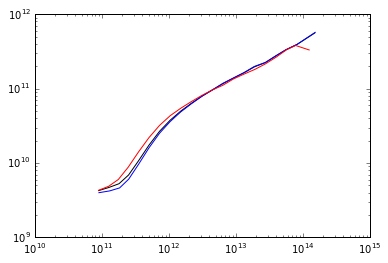

In [11]:
plt.plot(mpeak_mids_all, mean_sm_all, color='k', label='All')
plt.plot(mpeak_mids_cens, mean_sm_cens, color='blue', label='Centrals')
plt.plot(mpeak_mids_sats, mean_sm_sats, color='red', label='Satellites')
plt.loglog()

In [25]:
log_mean_sm1 = np.interp(np.log10(histories['mpeak']), np.log10(mpeak_mids_all), np.log10(mean_sm_all))
std_sm1 = np.interp(np.log10(histories['mpeak']), np.log10(mpeak_mids_all), std_sm_all)

log_mean_sm2 = np.zeros_like(newsm1)
std_sm2 = np.zeros_like(newsm1)

cenmask = histories['upid'] == -1
log_mean_sm2[cenmask] = np.interp(np.log10(histories['mpeak'][cenmask]), 
                              np.log10(mpeak_mids_cens), np.log10(mean_sm_cens))
log_mean_sm2[~cenmask] = np.interp(np.log10(histories['mpeak'][~cenmask]), 
                               np.log10(mpeak_mids_sats), np.log10(mean_sm_sats))
std_sm2[cenmask] = np.interp(np.log10(histories['mpeak'][cenmask]), 
                             np.log10(mpeak_mids_cens), std_sm_cens)
std_sm2[~cenmask] = np.interp(np.log10(histories['mpeak'][~cenmask]), 
                              np.log10(mpeak_mids_sats), std_sm_sats)

In [46]:
histories['smhm_sm'] = 10**np.random.normal(loc=log_mean_sm1, scale=std_sm1)
histories['censat_smhm_sm'] = 10**np.random.normal(loc=log_mean_sm2, scale=std_sm2)

# Compare the cen vs. sat SMHM

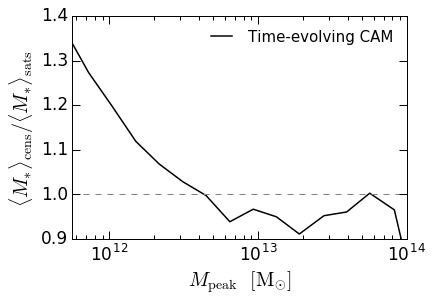

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\rm peak}$  ${\rm [M_{\odot}]}$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle M_{\ast} \rangle_{\rm cens} / \langle M_{\ast} \rangle_{\rm sats}$ ', fontsize=20)

lw=1.5
ax.plot(mpeak_mids_cens, mean_sm_sats/mean_sm_cens, 
        color='k', linewidth=lw, label='Time-evolving CAM')
ax.plot(np.logspace(10, 15, 100), np.ones(100), '--', color='gray')

plt.legend(frameon=False, loc='lower right', fontsize=15)

plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin=10**11.75, xmax=10**14)
plt.ylim(ymin=0.9, ymax=1.4)
ax.tick_params(axis='x', length=8, width=1, which='major')
ax.tick_params(axis='x', length=4, width=1, which='minor')
ax.tick_params(axis='y', length=8, width=1, which='major')
ax.tick_params(axis='y', length=4, width=1, which='minor')
plt.legend(frameon=False, loc='upper right', fontsize=15)

fig.savefig('FIGS/cen_vs_sat_smhm.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Compare the clustering

In [113]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array
rbins = np.logspace(-1.25, 1.5, 15)
rmids = 10**((np.log10(rbins[:-1]) + np.log10(rbins[1:]))/2.)

In [114]:
mask1 = (histories['sm'] > 10**10) & (histories['sm'] < 10**10.5)
mask2 = (histories['smhm_sm'] > 10**10) & (histories['smhm_sm'] < 10**10.5)
mask3 = (histories['censat_smhm_sm'] > 10**10) & (histories['censat_smhm_sm'] < 10**10.5)

In [115]:
pos1 = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], mask=mask1)
pos2 = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], mask=mask2)
pos3 = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], mask=mask3)

In [116]:
xi1 = tpcf(pos1, rbins, period=250., num_threads='max')
xi2 = tpcf(pos2, rbins, period=250., num_threads='max')
xi3 = tpcf(pos3, rbins, period=250., num_threads='max')

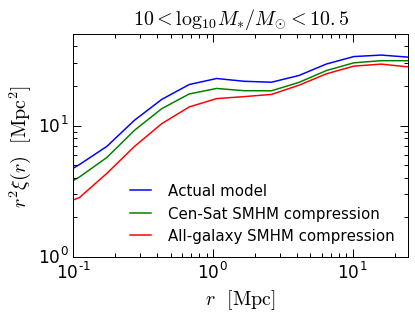

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$r$  ${\rm [Mpc]}$', fontsize=20)
ylabel = ax.set_ylabel(r'$r^{2}\xi(r)$  ${\rm [Mpc^{2}]}$', fontsize=20)
title = ax.set_title(r'$10 < \log_{10}M_{\ast}/M_{\odot} < 10.5$', fontsize=20, y=1.02) # y param fixes an overhanging title

lw=1.5
ax.plot(rmids, rmids*rmids*xi1, color='blue', label='Actual model', linewidth=lw)
ax.plot(rmids, rmids*rmids*xi3, color='green', label='Cen-Sat SMHM compression', linewidth=lw)
ax.plot(rmids, rmids*rmids*xi2, color='red', label='All-galaxy SMHM compression', linewidth=lw)


plt.legend(frameon=False, loc='lower right', fontsize=15)

plt.loglog()
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin=0.1, xmax=25)
plt.ylim(ymin=1, ymax=50)
ax.tick_params(axis='x', length=8, width=1, which='major')
ax.tick_params(axis='x', length=4, width=1, which='minor')
ax.tick_params(axis='y', length=8, width=1, which='major')
ax.tick_params(axis='y', length=4, width=1, which='minor')

fig.savefig('FIGS/smhm_compression_clustering_impact_10_10.5.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [118]:
ratio_all = (xi2 - xi1)/xi1
ratio_censat = (xi3 - xi1)/xi1

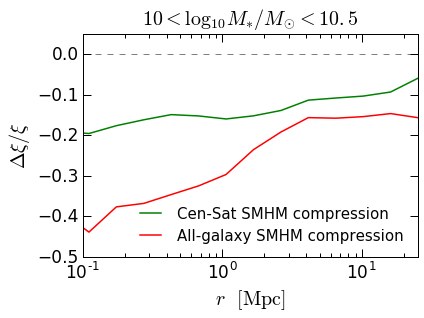

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$r$  ${\rm [Mpc]}$', fontsize=20)
ylabel = ax.set_ylabel(r'$\Delta\xi / \xi$', fontsize=20)
title = ax.set_title(r'$10 < \log_{10}M_{\ast}/M_{\odot} < 10.5$', fontsize=20, y=1.02) # y param fixes an overhanging title

lw=1.5
ax.plot(rmids, ratio_censat, color='green', label='Cen-Sat SMHM compression', linewidth=lw)
ax.plot(rmids, ratio_all, color='red', label='All-galaxy SMHM compression', linewidth=lw)
ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='gray')

plt.legend(frameon=False, loc='lower right', fontsize=15)

plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin=0.1, xmax=25)
plt.ylim(ymin=-0.5, ymax=0.05)
ax.tick_params(axis='x', length=8, width=1, which='major')
ax.tick_params(axis='x', length=4, width=1, which='minor')
ax.tick_params(axis='y', length=8, width=1, which='major')
ax.tick_params(axis='y', length=4, width=1, which='minor')

fig.savefig('FIGS/smhm_compression_clustering_ratio_10_10.5.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')